In [1]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [2]:
from transformers import ViTFeatureExtractor

model_ckpt = 'google/vit-base-patch16-224-in21k'
feature_extractor = ViTFeatureExtractor.from_pretrained(model_ckpt)

/home/rkn/.local/share/virtualenvs/lab-work-gFKfzxI5/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/rkn/.local/share/virtualenvs/lab-work-gFKfzxI5/lib/python3.10/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [3]:
images_root = 'Affectnet/Manually_Annotated/Manually_Annotated_Images'

In [4]:
import pandas as pd
from torch.utils.data import Dataset
from PIL import Image
import os


def pil_loader(path):
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')

class AffectNetDataset(Dataset):
    def __init__(self,
                 csvfile,
                 root,
                 mode='classification',
                 crop=False,
                 transform=None,
                 invalid_files=None):
        self.df = pd.read_csv(csvfile)
        self.root = root
        self.mode = mode
        self.crop = crop
        self.transform = transform
        self.invalid_files = invalid_files
        
        if self.invalid_files:
            self.df = self.df[~self.df['subDirectory_filePath'].isin(invalid_files)]
            self.df = self.df
        
        self.df = self.df[~((self.df['expression'] == 9) | (self.df['expression'] == 10))].reset_index(drop=True)
    
    def __getitem__(self, idx):
        try:
            img = pil_loader(os.path.join(self.root, self.df['subDirectory_filePath'][idx]))
        except KeyError:
            raise IndexError
        if self.crop:
            img = img.crop((self.df['face_x'][idx],
                            self.df['face_y'][idx],
                            self.df['face_x'][idx]+self.df['face_width'][idx],
                            self.df['face_y'][idx]+self.df['face_height'][idx],))
        if self.transform:
            img = self.transform(img)
        if self.mode == 'classification':
            target = torch.tensor(self.df['expression'][idx])
        elif self.mode == 'valence':
            target = torch.tensor([self.df['valence'][idx]])
        elif self.mode == 'arousal':
            target = torch.tensor([self.df['arousal'][idx]])
        else:
            target = torch.tensor([self.df['valence'][idx],
                                   self.df['arousal'][idx]])
        return img.float(), target.float()
    
    def __len__(self):
        return len(self.df)

In [5]:
def collate_fn(examples):
    imgs, targets = zip(*examples)
    pixel_values = torch.stack(imgs)
    targets = torch.stack(targets)
    return {'pixel_values': pixel_values, 'labels': targets}

In [6]:
train_invalid_files = ['103/29a31ebf1567693f4644c8ba3476ca9a72ee07fe67a5860d98707a0a.jpg']
val_invalid_files = []

In [7]:
mode = 'valence-arousal'
seed = 0

In [8]:
from torchvision.transforms import (Compose,
                                    Normalize,
                                    Resize,
                                    ToTensor)
from torch.utils.data import random_split


normalize = Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)

transform = Compose([Resize(tuple(feature_extractor.size.values())),
                     ToTensor()])

train_dataset = AffectNetDataset('Affectnet/training.csv',
                                 images_root,
                                 mode,
                                 crop=False,
                                 transform=transform,
                                 invalid_files=train_invalid_files)

val_dataset = AffectNetDataset('Affectnet/validation.csv',
                               images_root,
                               mode,
                               crop=False,
                               transform=transform,
                               invalid_files=val_invalid_files)

print('train:', len(train_dataset))
print('validation:', len(val_dataset))


train: 320739
validation: 4500


In [9]:
from transformers import ViTForImageClassification

model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k',
                                                  num_labels=2,
                                                  problem_type='regression')


Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Balanced MSE
- paper: https://openaccess.thecvf.com/content/CVPR2022/papers/Ren_Balanced_MSE_for_Imbalanced_Visual_Regression_CVPR_2022_paper.pdf
- github: https://github.com/jiawei-ren/BalancedMSE/tree/main

Batch-based Monte-Carlo (BMC)を使う

In [10]:
import torch.nn.functional as F
from torch.nn.modules.loss import _Loss
from torch.distributions import MultivariateNormal as MVN

def bmc_loss_md(pred, target, noise_var, device):
    I = torch.eye(pred.shape[-1]).to(device)
    logits = MVN(pred.unsqueeze(1), noise_var*I).log_prob(target.unsqueeze(0))
    loss = F.cross_entropy(logits, torch.arange(pred.shape[0]).to(device))
    loss = loss * (2 * noise_var).detach()
    
    return loss

class BMCLoss(_Loss):
    def __init__(self, init_noise_sigma=1., device=None, root=False):
        super(BMCLoss, self).__init__()
        self.noise_sigma = torch.nn.Parameter(torch.tensor(init_noise_sigma))
        self.device = device
        self.root = root
    
    def forward(self, pred, target):
        noise_var = self.noise_sigma ** 2
        loss = bmc_loss_md(pred, target, noise_var, self.device)
        return torch.sqrt(loss) if self.root else loss

In [11]:
from transformers import Trainer

class BMCLossTrainer(Trainer):
    def __init__(self,
                 model = None,
                 args = None,
                 data_collator = None,
                 train_dataset = None,
                 eval_dataset = None,
                 tokenizer = None,
                 model_init = None,
                 compute_metrics = None,
                 callbacks = None,
                 optimizers = (None, None),
                 preprocess_logits_for_metrics = None):
        super().__init__(model, args, data_collator, train_dataset, eval_dataset, tokenizer, model_init, compute_metrics, callbacks, optimizers, preprocess_logits_for_metrics)
        self.loss_fct = BMCLoss(device=self.args.device).to(self.args.device)
    
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get('labels')
        outputs = model(**inputs)
        logits = outputs.get('logits')
        loss = self.loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

In [12]:
from transformers import TrainingArguments
import wandb

wandb.init(project='AffectNet-vit', name='arousal-valence')

args = TrainingArguments(
    f"affectnet-balancedMSE-aroval-no910",
    save_strategy="epoch",
    evaluation_strategy="epoch",
    learning_rate=1e-6,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=16,
    num_train_epochs=30,
    weight_decay=1e-3,
    load_best_model_at_end=True,
    logging_dir='logs',
    remove_unused_columns=False,
    report_to='wandb'
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: rkn. Use `wandb login --relogin` to force relogin


In [13]:
from sklearn.metrics import mean_squared_error

def compute_metrics(eval_pred):
    preds, targets = eval_pred
    rmse = mean_squared_error(targets, preds, squared=False) / 2
    return {'rmse': rmse}

In [14]:
from transformers import EarlyStoppingCallback

trainer = BMCLossTrainer(
    model,
    args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    # compute_metrics=compute_bmse_metrics,
    tokenizer=feature_extractor,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

In [15]:
trainer.train()

/home/rkn/.local/share/virtualenvs/lab-work-gFKfzxI5/lib/python3.10/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
  0%|          | 500/300720 [08:29<81:45:23,  1.02it/s] 

{'loss': 6.8959, 'learning_rate': 9.98337323756318e-07, 'epoch': 0.05}


  0%|          | 1000/300720 [18:07<103:05:13,  1.24s/it]

{'loss': 6.6577, 'learning_rate': 9.966746475126364e-07, 'epoch': 0.1}


  0%|          | 1500/300720 [27:38<81:21:02,  1.02it/s] 

{'loss': 6.4542, 'learning_rate': 9.950119712689545e-07, 'epoch': 0.15}


  1%|          | 2000/300720 [37:05<83:50:28,  1.01s/it] 

{'loss': 6.3485, 'learning_rate': 9.933492950252726e-07, 'epoch': 0.2}


  1%|          | 2500/300720 [49:33<148:05:07,  1.79s/it]

{'loss': 6.3031, 'learning_rate': 9.916866187815907e-07, 'epoch': 0.25}


  1%|          | 3000/300720 [1:08:25<466:43:09,  5.64s/it]

{'loss': 6.248, 'learning_rate': 9.90023942537909e-07, 'epoch': 0.3}


  1%|          | 3500/300720 [1:41:42<252:06:33,  3.05s/it]

{'loss': 6.2128, 'learning_rate': 9.88361266294227e-07, 'epoch': 0.35}


  1%|▏         | 4000/300720 [1:59:24<92:39:25,  1.12s/it] 

{'loss': 6.2022, 'learning_rate': 9.866985900505454e-07, 'epoch': 0.4}


  1%|▏         | 4500/300720 [2:10:11<93:22:01,  1.13s/it] 

{'loss': 6.1669, 'learning_rate': 9.850359138068635e-07, 'epoch': 0.45}


  2%|▏         | 5000/300720 [2:20:18<114:28:59,  1.39s/it]

{'loss': 6.1479, 'learning_rate': 9.833732375631816e-07, 'epoch': 0.5}


  2%|▏         | 5500/300720 [2:31:07<77:03:17,  1.06it/s] 

{'loss': 6.127, 'learning_rate': 9.817105613194997e-07, 'epoch': 0.55}


  2%|▏         | 6000/300720 [2:40:36<83:15:51,  1.02s/it] 

{'loss': 6.096, 'learning_rate': 9.80047885075818e-07, 'epoch': 0.6}


  2%|▏         | 6500/300720 [2:50:00<92:56:21,  1.14s/it] 

{'loss': 6.1086, 'learning_rate': 9.783852088321361e-07, 'epoch': 0.65}


  2%|▏         | 7000/300720 [3:00:50<130:09:13,  1.60s/it]

{'loss': 6.0769, 'learning_rate': 9.767225325884544e-07, 'epoch': 0.7}


  2%|▏         | 7500/300720 [3:11:34<129:25:21,  1.59s/it]

{'loss': 6.0849, 'learning_rate': 9.750598563447725e-07, 'epoch': 0.75}


  3%|▎         | 8000/300720 [3:20:54<76:35:11,  1.06it/s] 

{'loss': 6.0659, 'learning_rate': 9.733971801010906e-07, 'epoch': 0.8}


  3%|▎         | 8500/300720 [3:30:22<82:51:56,  1.02s/it] 

{'loss': 6.0659, 'learning_rate': 9.71734503857409e-07, 'epoch': 0.85}


  3%|▎         | 9000/300720 [3:39:57<84:24:27,  1.04s/it] 

{'loss': 6.0519, 'learning_rate': 9.70071827613727e-07, 'epoch': 0.9}


  3%|▎         | 9500/300720 [3:51:19<110:09:03,  1.36s/it]

{'loss': 6.0362, 'learning_rate': 9.684091513700452e-07, 'epoch': 0.95}


  3%|▎         | 10000/300720 [4:01:08<83:14:12,  1.03s/it]

{'loss': 6.0311, 'learning_rate': 9.667464751263633e-07, 'epoch': 1.0}


                                                            
  3%|▎         | 10024/300720 [4:03:20<91:52:11,  1.14s/it]

{'eval_loss': 5.095004558563232, 'eval_rmse': 0.6602973341941833, 'eval_runtime': 103.6895, 'eval_samples_per_second': 43.399, 'eval_steps_per_second': 2.72, 'epoch': 1.0}


  3%|▎         | 10500/300720 [4:11:06<76:27:49,  1.05it/s]  

{'loss': 6.0144, 'learning_rate': 9.650837988826816e-07, 'epoch': 1.05}


  4%|▎         | 11000/300720 [4:19:14<78:21:37,  1.03it/s]

{'loss': 6.0074, 'learning_rate': 9.634211226389997e-07, 'epoch': 1.1}


  4%|▍         | 11500/300720 [4:27:28<82:23:20,  1.03s/it] 

{'loss': 5.9991, 'learning_rate': 9.61758446395318e-07, 'epoch': 1.15}


  4%|▍         | 12000/300720 [4:36:06<74:50:54,  1.07it/s] 

{'loss': 5.9825, 'learning_rate': 9.60095770151636e-07, 'epoch': 1.2}


  4%|▍         | 12500/300720 [4:44:40<79:06:38,  1.01it/s] 

{'loss': 5.9846, 'learning_rate': 9.584330939079542e-07, 'epoch': 1.25}


  4%|▍         | 13000/300720 [4:53:26<81:44:59,  1.02s/it] 

{'loss': 5.989, 'learning_rate': 9.567704176642723e-07, 'epoch': 1.3}


  4%|▍         | 13500/300720 [5:01:54<75:04:12,  1.06it/s] 

{'loss': 5.985, 'learning_rate': 9.551077414205906e-07, 'epoch': 1.35}


  5%|▍         | 14000/300720 [5:10:23<78:42:14,  1.01it/s] 

{'loss': 5.9541, 'learning_rate': 9.534450651769087e-07, 'epoch': 1.4}


  5%|▍         | 14500/300720 [5:18:32<80:37:37,  1.01s/it]

{'loss': 5.9527, 'learning_rate': 9.517823889332269e-07, 'epoch': 1.45}


  5%|▍         | 15000/300720 [5:27:04<78:02:06,  1.02it/s] 

{'loss': 5.9579, 'learning_rate': 9.50119712689545e-07, 'epoch': 1.5}


  5%|▌         | 15500/300720 [5:35:39<78:36:48,  1.01it/s] 

{'loss': 5.9581, 'learning_rate': 9.484570364458632e-07, 'epoch': 1.55}


  5%|▌         | 16000/300720 [5:43:49<76:46:07,  1.03it/s]

{'loss': 5.9566, 'learning_rate': 9.467943602021814e-07, 'epoch': 1.6}


  5%|▌         | 16500/300720 [5:52:12<79:21:51,  1.01s/it] 

{'loss': 5.945, 'learning_rate': 9.451316839584995e-07, 'epoch': 1.65}


  6%|▌         | 17000/300720 [6:00:30<78:45:19,  1.00it/s] 

{'loss': 5.9444, 'learning_rate': 9.434690077148177e-07, 'epoch': 1.7}


  6%|▌         | 17500/300720 [6:08:38<74:45:16,  1.05it/s]

{'loss': 5.9441, 'learning_rate': 9.418063314711358e-07, 'epoch': 1.75}


  6%|▌         | 18000/300720 [6:17:33<74:38:28,  1.05it/s] 

{'loss': 5.9598, 'learning_rate': 9.40143655227454e-07, 'epoch': 1.8}


  6%|▌         | 18500/300720 [6:26:02<77:17:22,  1.01it/s] 

{'loss': 5.9496, 'learning_rate': 9.384809789837723e-07, 'epoch': 1.85}


  6%|▋         | 19000/300720 [6:34:11<78:37:56,  1.00s/it] 

{'loss': 5.9305, 'learning_rate': 9.368183027400905e-07, 'epoch': 1.9}


  6%|▋         | 19500/300720 [6:42:20<71:34:08,  1.09it/s]

{'loss': 5.9194, 'learning_rate': 9.351556264964086e-07, 'epoch': 1.95}


  7%|▋         | 20000/300720 [6:50:31<73:58:22,  1.05it/s] 

{'loss': 5.9359, 'learning_rate': 9.334929502527268e-07, 'epoch': 2.0}


                                                           
  7%|▋         | 20048/300720 [6:53:01<59:07:12,  1.32it/s]

{'eval_loss': 5.006994247436523, 'eval_rmse': 0.7797415256500244, 'eval_runtime': 103.3285, 'eval_samples_per_second': 43.55, 'eval_steps_per_second': 2.729, 'epoch': 2.0}


  7%|▋         | 20500/300720 [7:00:33<69:01:07,  1.13it/s]  

{'loss': 5.9007, 'learning_rate': 9.318302740090449e-07, 'epoch': 2.05}


  7%|▋         | 21000/300720 [7:08:24<76:53:31,  1.01it/s]

{'loss': 5.9083, 'learning_rate': 9.301675977653632e-07, 'epoch': 2.09}


  7%|▋         | 21500/300720 [7:16:52<79:18:37,  1.02s/it] 

{'loss': 5.929, 'learning_rate': 9.285049215216813e-07, 'epoch': 2.14}


  7%|▋         | 22000/300720 [7:25:31<76:49:55,  1.01it/s] 

{'loss': 5.8964, 'learning_rate': 9.268422452779995e-07, 'epoch': 2.19}


  7%|▋         | 22500/300720 [7:33:56<82:33:12,  1.07s/it]

{'loss': 5.9066, 'learning_rate': 9.251795690343176e-07, 'epoch': 2.24}


  8%|▊         | 23000/300720 [7:42:28<76:16:42,  1.01it/s] 

{'loss': 5.8959, 'learning_rate': 9.235168927906357e-07, 'epoch': 2.29}


  8%|▊         | 23500/300720 [7:50:37<75:03:19,  1.03it/s]

{'loss': 5.9107, 'learning_rate': 9.218542165469539e-07, 'epoch': 2.34}


  8%|▊         | 24000/300720 [7:58:49<75:42:57,  1.02it/s]

{'loss': 5.8915, 'learning_rate': 9.201915403032721e-07, 'epoch': 2.39}


  8%|▊         | 24500/300720 [8:06:56<76:34:39,  1.00it/s]

{'loss': 5.8919, 'learning_rate': 9.185288640595903e-07, 'epoch': 2.44}


  8%|▊         | 25000/300720 [8:15:25<75:33:53,  1.01it/s] 

{'loss': 5.91, 'learning_rate': 9.168661878159084e-07, 'epoch': 2.49}


  8%|▊         | 25500/300720 [8:23:56<72:58:50,  1.05it/s] 

{'loss': 5.8655, 'learning_rate': 9.152035115722266e-07, 'epoch': 2.54}


  9%|▊         | 26000/300720 [8:32:30<72:37:19,  1.05it/s] 

{'loss': 5.8613, 'learning_rate': 9.135408353285447e-07, 'epoch': 2.59}


  9%|▉         | 26500/300720 [8:40:45<71:54:17,  1.06it/s] 

{'loss': 5.8881, 'learning_rate': 9.118781590848629e-07, 'epoch': 2.64}


  9%|▉         | 27000/300720 [8:49:00<141:05:54,  1.86s/it]

{'loss': 5.8852, 'learning_rate': 9.102154828411811e-07, 'epoch': 2.69}


  9%|▉         | 27500/300720 [8:57:21<77:08:31,  1.02s/it] 

{'loss': 5.8969, 'learning_rate': 9.085528065974994e-07, 'epoch': 2.74}


  9%|▉         | 28000/300720 [9:05:29<72:01:40,  1.05it/s] 

{'loss': 5.8913, 'learning_rate': 9.068901303538175e-07, 'epoch': 2.79}


  9%|▉         | 28500/300720 [9:13:48<71:46:24,  1.05it/s] 

{'loss': 5.8759, 'learning_rate': 9.052274541101357e-07, 'epoch': 2.84}


 10%|▉         | 29000/300720 [9:21:55<82:02:29,  1.09s/it]

{'loss': 5.8711, 'learning_rate': 9.035647778664538e-07, 'epoch': 2.89}


 10%|▉         | 29500/300720 [9:30:34<72:14:53,  1.04it/s] 

{'loss': 5.8662, 'learning_rate': 9.019021016227721e-07, 'epoch': 2.94}


 10%|▉         | 30000/300720 [9:38:43<74:11:04,  1.01it/s]

{'loss': 5.8714, 'learning_rate': 9.002394253790902e-07, 'epoch': 2.99}


                                                           
 10%|█         | 30072/300720 [9:41:36<67:16:24,  1.12it/s]

{'eval_loss': 4.948969841003418, 'eval_rmse': 0.8435841798782349, 'eval_runtime': 102.9213, 'eval_samples_per_second': 43.723, 'eval_steps_per_second': 2.74, 'epoch': 3.0}


 10%|█         | 30500/300720 [9:48:28<69:05:51,  1.09it/s]  

{'loss': 5.8689, 'learning_rate': 8.985767491354083e-07, 'epoch': 3.04}


 10%|█         | 31000/300720 [9:56:20<71:56:46,  1.04it/s]

{'loss': 5.8594, 'learning_rate': 8.969140728917265e-07, 'epoch': 3.09}


 10%|█         | 31500/300720 [10:04:41<74:11:48,  1.01it/s]

{'loss': 5.8618, 'learning_rate': 8.952513966480446e-07, 'epoch': 3.14}


 11%|█         | 32000/300720 [10:12:52<73:22:25,  1.02it/s]

{'loss': 5.8604, 'learning_rate': 8.935887204043628e-07, 'epoch': 3.19}


 11%|█         | 32500/300720 [10:21:32<80:10:35,  1.08s/it] 

{'loss': 5.8589, 'learning_rate': 8.91926044160681e-07, 'epoch': 3.24}


 11%|█         | 33000/300720 [10:30:27<70:47:36,  1.05it/s] 

{'loss': 5.844, 'learning_rate': 8.902633679169992e-07, 'epoch': 3.29}


 11%|█         | 33500/300720 [10:38:38<69:50:43,  1.06it/s]

{'loss': 5.8541, 'learning_rate': 8.886006916733173e-07, 'epoch': 3.34}


 11%|█▏        | 34000/300720 [10:46:49<75:11:29,  1.01s/it]

{'loss': 5.8501, 'learning_rate': 8.869380154296355e-07, 'epoch': 3.39}


 11%|█▏        | 34500/300720 [10:55:00<78:40:25,  1.06s/it]

{'loss': 5.8527, 'learning_rate': 8.852753391859536e-07, 'epoch': 3.44}


 12%|█▏        | 35000/300720 [11:04:35<77:35:08,  1.05s/it] 

{'loss': 5.857, 'learning_rate': 8.836126629422719e-07, 'epoch': 3.49}


 12%|█▏        | 35500/300720 [11:12:48<69:23:31,  1.06it/s]

{'loss': 5.8381, 'learning_rate': 8.8194998669859e-07, 'epoch': 3.54}


 12%|█▏        | 36000/300720 [11:21:06<67:18:36,  1.09it/s] 

{'loss': 5.8535, 'learning_rate': 8.802873104549082e-07, 'epoch': 3.59}


 12%|█▏        | 36500/300720 [11:29:43<71:24:10,  1.03it/s] 

{'loss': 5.8494, 'learning_rate': 8.786246342112263e-07, 'epoch': 3.64}


 12%|█▏        | 37000/300720 [11:37:57<72:46:03,  1.01it/s]

{'loss': 5.8529, 'learning_rate': 8.769619579675446e-07, 'epoch': 3.69}


 12%|█▏        | 37500/300720 [11:46:14<76:37:12,  1.05s/it] 

{'loss': 5.8316, 'learning_rate': 8.752992817238627e-07, 'epoch': 3.74}


 13%|█▎        | 38000/300720 [11:54:29<70:40:03,  1.03it/s]

{'loss': 5.8421, 'learning_rate': 8.736366054801809e-07, 'epoch': 3.79}


 13%|█▎        | 38500/300720 [12:02:41<70:44:02,  1.03it/s]

{'loss': 5.8477, 'learning_rate': 8.719739292364991e-07, 'epoch': 3.84}


 13%|█▎        | 39000/300720 [12:11:24<69:42:54,  1.04it/s] 

{'loss': 5.8329, 'learning_rate': 8.703112529928172e-07, 'epoch': 3.89}


 13%|█▎        | 39500/300720 [12:19:38<70:21:53,  1.03it/s]

{'loss': 5.8296, 'learning_rate': 8.686485767491354e-07, 'epoch': 3.94}


 13%|█▎        | 40000/300720 [12:27:52<66:50:51,  1.08it/s]

{'loss': 5.8513, 'learning_rate': 8.669859005054535e-07, 'epoch': 3.99}


                                                            
 13%|█▎        | 40096/300720 [12:31:09<53:38:55,  1.35it/s]

{'eval_loss': 4.963268280029297, 'eval_rmse': 0.9032064080238342, 'eval_runtime': 101.6894, 'eval_samples_per_second': 44.252, 'eval_steps_per_second': 2.773, 'epoch': 4.0}


 13%|█▎        | 40500/300720 [12:37:37<69:56:20,  1.03it/s]  

{'loss': 5.8234, 'learning_rate': 8.653232242617717e-07, 'epoch': 4.04}


 14%|█▎        | 41000/300720 [12:46:22<68:07:52,  1.06it/s] 

{'loss': 5.8325, 'learning_rate': 8.636605480180899e-07, 'epoch': 4.09}


 14%|█▍        | 41500/300720 [12:54:31<67:09:26,  1.07it/s]

{'loss': 5.8228, 'learning_rate': 8.619978717744081e-07, 'epoch': 4.14}


 14%|█▍        | 42000/300720 [13:02:51<68:53:45,  1.04it/s] 

{'loss': 5.8197, 'learning_rate': 8.603351955307262e-07, 'epoch': 4.19}


 14%|█▍        | 42500/300720 [13:11:22<69:01:38,  1.04it/s]

{'loss': 5.8091, 'learning_rate': 8.586725192870444e-07, 'epoch': 4.24}


 14%|█▍        | 43000/300720 [13:19:40<65:44:59,  1.09it/s] 

{'loss': 5.8114, 'learning_rate': 8.570098430433625e-07, 'epoch': 4.29}


 14%|█▍        | 43500/300720 [13:27:54<72:50:49,  1.02s/it]

{'loss': 5.8236, 'learning_rate': 8.553471667996808e-07, 'epoch': 4.34}


 15%|█▍        | 44000/300720 [13:36:08<68:52:45,  1.04it/s]

{'loss': 5.8195, 'learning_rate': 8.536844905559989e-07, 'epoch': 4.39}


 15%|█▍        | 44500/300720 [13:44:25<72:44:02,  1.02s/it]

{'loss': 5.8217, 'learning_rate': 8.520218143123171e-07, 'epoch': 4.44}


 15%|█▍        | 45000/300720 [13:52:53<71:18:34,  1.00s/it] 

{'loss': 5.8099, 'learning_rate': 8.503591380686352e-07, 'epoch': 4.49}


 15%|█▌        | 45500/300720 [14:01:11<69:12:33,  1.02it/s] 

{'loss': 5.8154, 'learning_rate': 8.486964618249533e-07, 'epoch': 4.54}


 15%|█▌        | 46000/300720 [14:09:24<65:49:22,  1.07it/s]

{'loss': 5.8395, 'learning_rate': 8.470337855812715e-07, 'epoch': 4.59}


 15%|█▌        | 46500/300720 [14:17:41<69:33:06,  1.02it/s]

{'loss': 5.8061, 'learning_rate': 8.453711093375898e-07, 'epoch': 4.64}


 16%|█▌        | 47000/300720 [14:26:00<88:49:20,  1.26s/it] 

{'loss': 5.8206, 'learning_rate': 8.43708433093908e-07, 'epoch': 4.69}


 16%|█▌        | 47500/300720 [14:35:16<75:10:57,  1.07s/it] 

{'loss': 5.8202, 'learning_rate': 8.420457568502261e-07, 'epoch': 4.74}


 16%|█▌        | 48000/300720 [14:43:29<70:13:45,  1.00s/it]

{'loss': 5.8049, 'learning_rate': 8.403830806065443e-07, 'epoch': 4.79}


 16%|█▌        | 48500/300720 [14:52:15<69:50:13,  1.00it/s] 

{'loss': 5.8313, 'learning_rate': 8.387204043628624e-07, 'epoch': 4.84}


 16%|█▋        | 49000/300720 [15:00:19<70:08:14,  1.00s/it] 

{'loss': 5.8098, 'learning_rate': 8.370577281191806e-07, 'epoch': 4.89}


 16%|█▋        | 49500/300720 [15:08:21<66:43:17,  1.05it/s]

{'loss': 5.8236, 'learning_rate': 8.353950518754988e-07, 'epoch': 4.94}


 17%|█▋        | 50000/300720 [15:16:47<68:07:35,  1.02it/s] 

{'loss': 5.7995, 'learning_rate': 8.33732375631817e-07, 'epoch': 4.99}


                                                            
 17%|█▋        | 50120/300720 [15:20:22<52:40:22,  1.32it/s]

{'eval_loss': 4.941766738891602, 'eval_rmse': 0.9373003840446472, 'eval_runtime': 100.3276, 'eval_samples_per_second': 44.853, 'eval_steps_per_second': 2.811, 'epoch': 5.0}


 17%|█▋        | 50500/300720 [15:26:16<60:58:53,  1.14it/s]  

{'loss': 5.8084, 'learning_rate': 8.320696993881351e-07, 'epoch': 5.04}


 17%|█▋        | 51000/300720 [15:34:20<65:25:52,  1.06it/s] 

{'loss': 5.7827, 'learning_rate': 8.304070231444533e-07, 'epoch': 5.09}


 17%|█▋        | 51500/300720 [15:42:37<65:58:54,  1.05it/s] 

{'loss': 5.792, 'learning_rate': 8.287443469007714e-07, 'epoch': 5.14}


 17%|█▋        | 52000/300720 [15:50:46<65:02:57,  1.06it/s] 

{'loss': 5.7937, 'learning_rate': 8.270816706570897e-07, 'epoch': 5.19}


 17%|█▋        | 52500/300720 [15:58:52<75:14:37,  1.09s/it]

{'loss': 5.7849, 'learning_rate': 8.254189944134078e-07, 'epoch': 5.24}


 18%|█▊        | 53000/300720 [16:07:06<65:37:41,  1.05it/s]

{'loss': 5.7936, 'learning_rate': 8.237563181697259e-07, 'epoch': 5.29}


 18%|█▊        | 53500/300720 [16:15:37<72:17:47,  1.05s/it] 

{'loss': 5.788, 'learning_rate': 8.220936419260441e-07, 'epoch': 5.34}


 18%|█▊        | 54000/300720 [16:24:23<67:18:04,  1.02it/s] 

{'loss': 5.7814, 'learning_rate': 8.204309656823622e-07, 'epoch': 5.39}


 18%|█▊        | 54500/300720 [16:32:29<70:02:35,  1.02s/it] 

{'loss': 5.7984, 'learning_rate': 8.187682894386804e-07, 'epoch': 5.44}


 18%|█▊        | 55000/300720 [16:40:29<66:47:47,  1.02it/s]

{'loss': 5.811, 'learning_rate': 8.171056131949986e-07, 'epoch': 5.49}


 18%|█▊        | 55500/300720 [16:48:34<66:25:59,  1.03it/s]

{'loss': 5.7926, 'learning_rate': 8.154429369513168e-07, 'epoch': 5.54}


 19%|█▊        | 56000/300720 [16:57:01<67:25:55,  1.01it/s] 

{'loss': 5.8003, 'learning_rate': 8.13780260707635e-07, 'epoch': 5.59}


 19%|█▊        | 56170/300720 [17:00:18<73:16:36,  1.08s/it] 
KeyboardInterrupt



In [16]:
trainer.save_state()
trainer.save_model()
wandb.finish()

eval/loss,█▄▁▂▁
eval/rmse,▁▄▆▇█
eval/runtime,█▇▆▄▁
eval/samples_per_second,▁▂▃▅█
eval/steps_per_second,▁▂▃▅█
train/epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/learning_rate,███▇▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁
train/loss,█▅▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval/loss,4.94177
eval/rmse,0.9373


In [9]:
from tqdm import tqdm

def CLE_tokens(model, tokenizer, dataset, device):
    tokens = []
    labels = []
    for img, label in tqdm(dataset):
        feature = tokenizer(img, return_tensors='pt').pixel_values.to(device)
        with torch.no_grad():
            token = model(feature, output_hidden_states=True).hidden_states[-1][0,0,:]
        tokens.append(token.cpu())
        labels.append(label)
    return torch.stack(tokens).squeeze(), torch.stack(labels)

In [10]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from umap import UMAP
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
import random

def plot_tokens(tokens, targets, n_neighbors):
    fig = plt.figure(figsize=(15, 15))
    plt.subplots_adjust(wspace=0.4, hspace=0.6)
    for i, category in enumerate(['valence', 'arousal']):
        umap = UMAP(n_neighbors=n_neighbors)
        xy = np.array(umap.fit_transform(tokens.numpy()))
        x = xy[:, 0]
        y = xy[:, 1]
        z = targets[:, i]
        ax = fig.add_subplot(1, 2, i+1)
        ax.set_aspect('equal', adjustable='box')
        ax.set_xlabel('feature-1')
        ax.set_ylabel('feature-2')
        ax.set_title(category)
        mp = ax.scatter(x, y,
                        alpha=1,
                        c=z,
                        cmap='Oranges',
                        vmin=-1,
                        vmax=1,
                        s=3)
        fig.colorbar(mp, ax=ax, shrink=0.335)
    plt.show()
    return fig


In [11]:
from transformers import ViTForImageClassification

model = ViTForImageClassification.from_pretrained('affectnet-balancedMSE-aroval-no910',
                                                  num_labels=2,
                                                  problem_type='regression').to(device)

In [12]:
tokens, targets = CLE_tokens(model,
                             feature_extractor,
                             val_dataset,
                             device)
print(tokens.shape, targets.shape)

100%|██████████| 4500/4500 [00:51<00:00, 86.98it/s] 

torch.Size([4500, 768]) torch.Size([4500, 2])


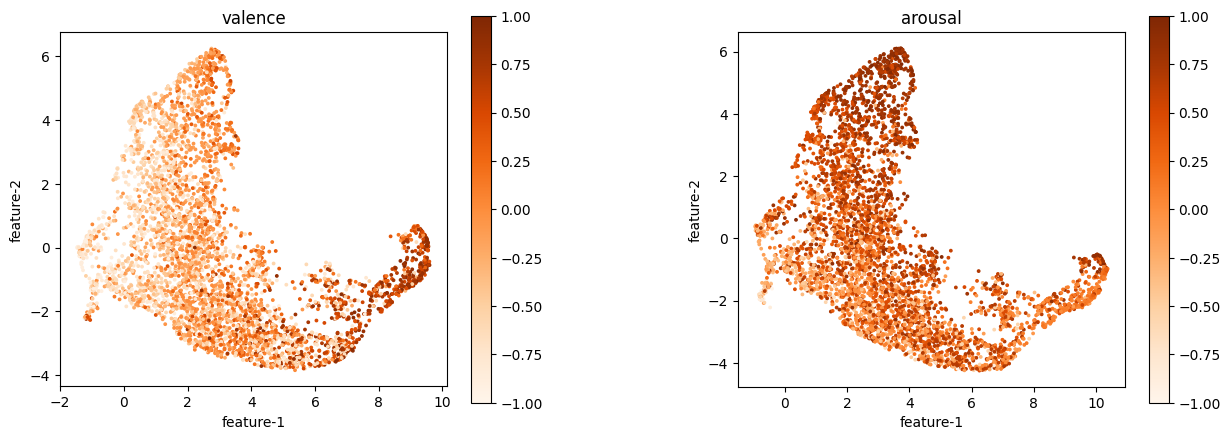

In [13]:
finetuned_fig = plot_tokens(tokens, targets, 30)


In [14]:
from transformers import ViTForImageClassification

non_finetued_model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k',
                                                               num_labels=2,
                                                               problem_type='regression').to(device)

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


100%|██████████| 4500/4500 [02:47<00:00, 26.83it/s]


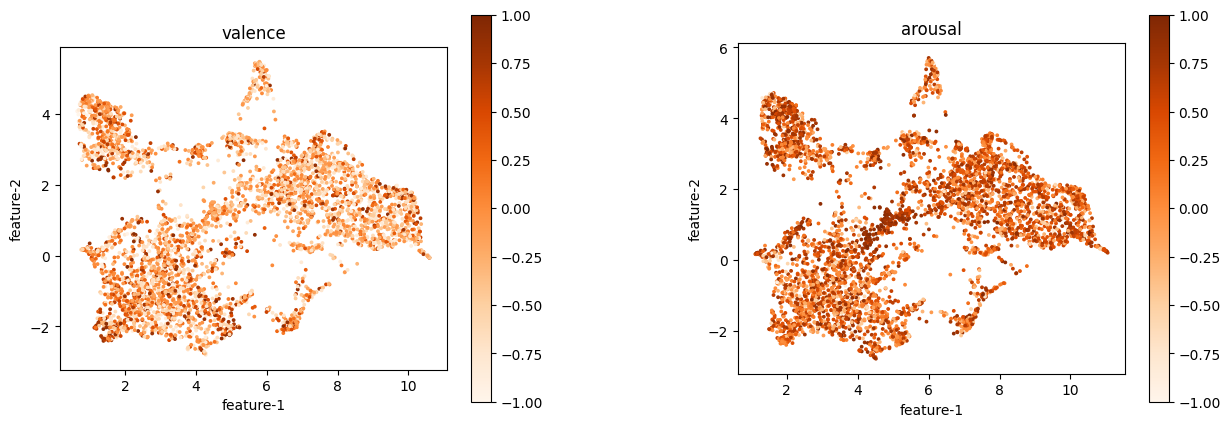

In [15]:
tokens, targets = CLE_tokens(non_finetued_model,
                             feature_extractor,
                             val_dataset,
                             device)
non_finetuned_fig = plot_tokens(tokens, targets, 30)

In [16]:
import wandb
wandb.init(project='AffectNet-vit', name='arousal-valence-result0402')


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: rkn. Use `wandb login --relogin` to force relogin


In [18]:
wandb.log({'finetuned-plot': wandb.Image(finetuned_fig), 'non-finetuned-plot': wandb.Image(non_finetuned_fig)})